## Feature selection

Boruta is an advanced feature selection method that uses Random Forest as a base algorithm. Its goal is to identify all relevant features in a dataset, including those that might have a weaker impact on the model's predictive power but are still significant. It is particularly useful for datasets with many features where traditional methods of feature selection (such as mutual information or simple feature importance) might miss some important variables.


The main steps of the Boruta algorithm are:

Create Shadow Features:

For each feature in the dataset, create a shadow feature by randomly permuting (shuffling) the feature’s values. This step helps in understanding how important the real features are compared to random noise.
For example, if you have 10 original features, Boruta will create 10 shadow features.
Train Random Forest:

A Random Forest model is trained using the original features along with the shadow features. This model is used to rank the importance of each feature based on how it improves model performance.
Ranking Features:

The importance of each feature is determined by how much it contributes to reducing the impurity (e.g., Gini impurity) in the Random Forest. The higher the feature's contribution to impurity reduction, the more important the feature is considered.
Feature Comparison:

Each original feature is compared against its corresponding shadow feature’s importance. If the original feature has higher importance than its shadow feature, it is considered relevant.
Features are ranked based on their importance, and shadow features are always considered irrelevant.
Feature Elimination:

Boruta eliminates irrelevant features and keeps features that have higher importance than the shadow features. A feature is removed if its importance is significantly less than the highest shadow feature.
Iteration:

This process is repeated multiple times (usually several hundred iterations) to refine the ranking of features. The final set of selected features is determined based on consistent importance across the iterations.
Final Decision:

Once the algorithm has iterated enough, it returns a final list of features that are either:
Confirmed: Features that are significantly more important than their shadow counterparts.
Rejected: Features that are consistently less important than their shadow counterparts.
Tentative: Features that have mixed importance but may be relevant depending on the model.

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [102]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [103]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [104]:
imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(random_state=42),
    random_state=42,
)

imputer_missForest.fit(X_train)
X_train_missForest = imputer_missForest.transform(X_train)
X_test_missForest = imputer_missForest.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [105]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [106]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [107]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [108]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((425, 23), (183, 23))

In [109]:
model = RandomForestClassifier(random_state=42,)

# let's initialize Boruta
sel = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
)

sel.fit(X_train_t.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	10
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	10
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	10
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	10
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	9
Rejected: 	6
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	8
Rejected: 	7
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	8
Rejected: 	7
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	8
Rejected: 	7
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	4
Rejected: 	10
Itera

BorutaPy(estimator=RandomForestClassifier(n_estimators=48,
                                          random_state=RandomState(MT19937) at 0x19499FCF540),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x19499FCF540, verbose=2)

In [110]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(sel.support_)):
    if sel.support_[i]:
        print("Passes the test: ", X_train_t.columns[i],
              " - Ranking: ", sel.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X_train_t.columns[i], " - Ranking: ", sel.ranking_[i])


------Support and Ranking for each feature------
Passes the test:  RID  - Ranking:  1
Doesn't pass the test:  Gender  - Ranking:  14
Passes the test:  Ageatscreening  - Ranking:  1
Passes the test:  MMSE0m  - Ranking:  1
Doesn't pass the test:  HipsASMbaseline  - Ranking:  12
Doesn't pass the test:  HipsContrastbaseline  - Ranking:  2
Doesn't pass the test:  HipsCorelationbaseline  - Ranking:  8
Doesn't pass the test:  HipsVariancebaseline  - Ranking:  10
Doesn't pass the test:  HipsSumAveragebaseline  - Ranking:  5
Doesn't pass the test:  HipsSumVariancebaseline  - Ranking:  8
Passes the test:  HipsEntropybaseline  - Ranking:  1
Doesn't pass the test:  HipsClusterShadebaseline  - Ranking:  2
Doesn't pass the test:  ERCsASMbaseline  - Ranking:  13
Passes the test:  ERCsContrastbaseline  - Ranking:  1
Passes the test:  ERCsCorelationbaseline  - Ranking:  1
Doesn't pass the test:  ERCsVariancebaseline  - Ranking:  11
Doesn't pass the test:  ERCsSumAveragebaseline  - Ranking:  7
Doesn't 

In [111]:
# Store selected feature names before transformation
selected_features = X_train_t.columns[sel.support_]
selected_features

Index(['RID', 'Ageatscreening', 'MMSE0m', 'HipsEntropybaseline',
       'ERCsContrastbaseline', 'ERCsCorelationbaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline'],
      dtype='object')

<Axes: >

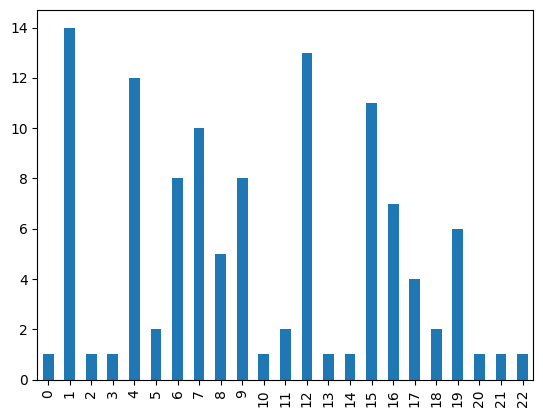

In [112]:
ranking = sel.ranking_
plot_ranking = pd.Series(ranking)
plot_ranking.plot(kind="bar")

In [113]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((425, 9), (183, 9))

## Classification Test

In [114]:
def run_model(classifier_name, X_train, y_train):

        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False) 

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [115]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_missForest_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_missForest_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_missForest_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

In [116]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Fit Time", "Total Features", "Metric"])
validation_df_report

Mean Train  \
Feature Selection Classifier    Fit Time Total Features Metric                          
Boruta            Random Forest 0.285    23             balanced_accuracy       0.895   
                                0.257    9              balanced_accuracy       0.856   
                  XGBoost       0.567    23             balanced_accuracy       1.000   
                                0.352    9              balanced_accuracy       1.000   
                  NGBoost       1.716    23             balanced_accuracy       0.690   
                                1.036    9              balanced_accuracy       0.663   

                                                                           Std Train  \
Feature Selection Classifier    Fit Time Total Features Metric                         
Boruta            Random Forest 0.285    23             balanced_accuracy      0.010   
                                0.257    9              balanced_accuracy      0.012   
                  XGBoost       0.567    23             balanced_accuracy      0.000   
                                0.352    9              balanced_accuracy      0.000   
                  NGBoost       1.716    23             balanced_accuracy      0.018   
                                1.036    9              balanced_accuracy      0.010   

                                                                           Mean Test  \
Feature Selection Classifier    Fit Time Total Features Metric                         
Boruta            Random Forest 0.285    23             balanced_accuracy      0.561   
                                0.257    9              balanced_accuracy      0.561   
                  XGBoost       0.567    23             balanced_accuracy      0.542   
                                0.352    9              balanced_accuracy      0.566   
                  NGBoost       1.716    23             balanced_accuracy      0.549   
                                1.036    9              balanced_accuracy      0.543   

                                                                           Std Test  
Feature Selection Classifier    Fit Time Total Features Metric                       
Boruta            Random Forest 0.285    23             balanced_accuracy     0.071  
                                0.257    9              balanced_accuracy     0.049  
                  XGBoost       0.567    23             balanced_accuracy     0.034  
                                0.352    9              balanced_accuracy     0.059  
                  NGBoost       1.716    23             balanced_accuracy     0.061  
                                1.036    9              balanced_accuracy     0.046

In [117]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [118]:
results = "filtered"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier    Classification Time Total Features Metric                             
Boruta            Random Forest 0.139               9              accuracy                   0.840   
                                                                   balanced_accuracy          0.849   
                                                                   precision                  0.850   
                                                                   recall                     0.840   
                                                                   f1_weighted                0.838   
                                                                   roc_auc_ovr_weighted       0.966   
                  XGBoost       0.118               9              accuracy                   1.000   
                                                                   balanced_accuracy          1.000   
                                                                   precision                  1.000   
                                                                   recall                     1.000   
                                                                   f1_weighted                1.000   
                                                                   roc_auc_ovr_weighted       1.000   
                  NGBoost       0.408               9              accuracy                   0.744   
                                                                   balanced_accuracy          0.655   
                                                                   precision                  0.733   
                                                                   recall                     0.744   
                                                                   f1_weighted                0.712   
                                                                   roc_auc_ovr_weighted       0.935   

                                                                                         Test data  
Feature Selection Classifier    Classification Time Total Features Metric                           
Boruta            Random Forest 0.139               9              accuracy                  0.563  
                                                                   balanced_accuracy         0.556  
                                                                   precision                 0.562  
                                                                   recall                    0.563  
                                                                   f1_weighted               0.558  
                                                                   roc_auc_ovr_weighted      0.839  
                  XGBoost       0.118               9              accuracy                  0.590  
                                                                   balanced_accuracy         0.568  
                                                                   precision                 0.575  
                                                                   recall                    0.590  
                                                                   f1_weighted               0.577  
                                                                   roc_auc_ovr_weighted      0.841  
                  NGBoost       0.408               9              accuracy                  0.596  
                                                                   balanced_accuracy         0.572  
                                                                   precision                 0.577  
                                                                   recall                    0.596  
                                                                   f1_weighted               0.553  
                                                                   roc_auc_ovr_weighted      0.828